In [24]:
import h2o
import os
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

## Load data and initialize h2o

In [2]:
with open('data/cc_merged_0412.pkl', 'rb') as f:
    rawdata = pickle.load(f)

In [3]:
h2o.init(max_mem_size = "2G")             #specify max number of bytes. uses all cores by default.
h2o.remove_all()                          #clean slate, in case cluster was already running

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_131"; Java(TM) SE Runtime Environment (build 1.8.0_131-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.131-b11, mixed mode)
  Starting server from /Users/wangruofan/anaconda3/envs/py36/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/xk/q16tpt9s72q2g2nvfv69nvcw0000gn/T/tmpyp47z_yy
  JVM stdout: /var/folders/xk/q16tpt9s72q2g2nvfv69nvcw0000gn/T/tmpyp47z_yy/h2o_wangruofan_started_from_python.out
  JVM stderr: /var/folders/xk/q16tpt9s72q2g2nvfv69nvcw0000gn/T/tmpyp47z_yy/h2o_wangruofan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.7
H2O cluster version age:,"7 days, 1 hour and 36 minutes"
H2O cluster name:,H2O_from_python_wangruofan_aucic6
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [4]:
data = h2o.H2OFrame(rawdata)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
data.summary()

index year caseid opinion_type judge_name decision date Author Affirmed AffirmedInPart Reversed ReversedInPart Vacated VacatedInPart Circuit judgeid1 judgeid2 judgeid3 x_dem_x x_republican_x x_instate_ba_x x_elev_x x_unity_x x_aba_x x_crossa_x x_pfedjdge_x x_pindreg1_x x_plawprof_x x_pscab_x x_pcab_x x_pusa_x x_pssenate_x x_paag_x x_psp_x x_pslc_x x_pssc_x x_pshouse_x x_psg_x x_psgo_x x_psenate_x x_psatty_x x_pprivate_x x_pmayor_x x_plocct_x x_phouse_x x_pgov_x x_pda_x x_pcc_x x_pccoun_x x_pausa_x x_pasatty_x x_pag_x x_pada_x x_pgovt_x x_llm_sjd_x x_protestant_x x_evangelical_x x_mainline_x x_noreligion_x x_catholic_x x_jewish_x x_black_x x_nonwhite_x x_female_x x_jd_public_x x_ba_public_x x_b10s_x x_b20s_x x_b30s_x x_b40s_x x_b50s_x x_pbank_x x_pmag_x x_ageon40s_x x_ageon50s_x x_ageon60s_x x_ageon40orless_x x_ageon70ormore_x x_pago_x x_apptoter_x x_dccircuit_x x_8circuit_x x_11circuit_x x_fcircuit_x x_5circuit_x x_1circuit_x x_4circuit_x x_9circuit_x x_2circuit_x x_7circuit_x x_6circuit_x x_10circuit_x x_3circuit_x id_x x_term_x x_circuit_x x_hdem_x x_hrep_x x_sdem_x x_srep_x x_hother_x x_sother_x x_agecommi_x fullname_x lastname_x firstname_x middlename_x suffix_x x_dem_y x_republican_y x_instate_ba_y x_elev_y x_unity_y x_aba_y x_crossa_y x_pfedjdge_y x_pindreg1_y x_plawprof_y x_pscab_y x_pcab_y x_pusa_y x_pssenate_y x_paag_y x_psp_y x_pslc_y x_pssc_y x_pshouse_y x_psg_y x_psgo_y x_psenate_y x_psatty_y x_pprivate_y x_pmayor_y x_plocct_y x_phouse_y x_pgov_y x_pda_y x_pcc_y x_pccoun_y x_pausa_y x_pasatty_y x_pag_y x_pada_y x_pgovt_y x_llm_sjd_y x_protestant_y x_evangelical_y x_mainline_y x_noreligion_y x_catholic_y x_jewish_y x_black_y x_nonwhite_y x_female_y x_jd_public_y x_ba_public_y x_b10s_y x_b20s_y x_b30s_y x_b40s_y x_b50s_y x_pbank_y x_pmag_y x_ageon40s_y x_ageon50s_y x_ageon60s_y x_ageon40orless_y x_ageon70ormore_y x_pago_y x_apptoter_y x_dccircuit_y x_8circuit_y x_11circuit_y x_fcircuit_y x_5circuit_y x_1circuit_y x_4circuit_y x_9circuit_y x_2circuit_y x_7circuit_y x_6circuit_y x_10circuit_y x_3circuit_y id_y x_term_y x_circuit_y x_hdem_y x_hrep_y x_sdem_y x_srep_y x_hother_y x_sother_y x_agecommi_y fullname_y lastname_y firstname_y middlename_y suffix_y x_dem x_republican x_instate_ba x_elev x_unity x_aba x_crossa x_pfedjdge x_pindreg1 x_plawprof x_pscab x_pcab x_pusa x_pssenate x_paag x_psp x_pslc x_pssc x_pshouse x_psg x_psgo x_psenate x_psatty x_pprivate x_pmayor x_plocct x_phouse x_pgov x_pda x_pcc x_pccoun x_pausa x_pasatty x_pag x_pada x_pgovt x_llm_sjd x_protestant x_evangelical x_mainline x_noreligion x_catholic x_jewish x_black x_nonwhite x_female x_jd_public x_ba_public x_b10s x_b20s x_b30s x_b40s x_b50s x_pbank x_pmag x_ageon40s x_ageon50s x_ageon60s x_ageon40orless x_ageon70ormore x_pago x_apptoter x_dccircuit x_8circuit x_11circuit x_fcircuit x_5circuit x_1circuit x_4circuit x_9circuit x_2circuit x_7circuit x_6circuit x_10circuit x_3circuit id x_term x_circuit x_hdem x_hrep x_sdem x_srep x_hother x_sother x_agecommi fullname lastname firstname middlename suffix month_3 length_3m month_6 length_6m month_3m_b month_3_b length_3m_dif txt x_dem_p 
 
 
 type int int string enum enum enum time enum int int int int int int int int int int int int int int int int int int int int int int int int int int int int int int int int int int int int int int int int int int enum int int int int int int int int int int int int int int int int int int int int int int int int int int int int enum int int int int int int int int int int int int int int int int int int int int int int int enum enum enum enum enum int int int int int int int int int int int int int int int int int int int int int int int int int int int int int int int int enum int int int int int int int int int int int int int int int int int int int int int int int int int int int int enum int int int int int int int int int int int int int int int int int int int int int int int enum enum enum enum enum int int int int int int int int int int int int int i

In [6]:
#h2o groupby example
data.group_by("opinion_type").sum('Affirmed').get_frame()

opinion_type,sum_Affirmed
contentConDisOp1,17
contentConOp,8
contentConOp1,32
contentConOp2,3
contentConPartOp,5
contentDisOp,7
contentDisOp1,63
contentDisPartOp,5
contentMajOp,5828
contentPerCurOp,119


## Generate target variable

In [7]:
data = data[sum(data[:,["Affirmed","AffirmedInPart","Reversed","ReversedInPart","Vacated","VacatedInPart"]]) == 1,:]#.sum(axis=0)
data["res"] = 0

# data = data.as_data_frame(use_pandas=True)
# data = data[data["res"] == 1,:] 
# data = h2o.H2OFrame(data)
data[data["Affirmed"] == 1, "res"] = 1
data[data["Reversed"] == 1, "res"] = 2
data[data["Vacated"] == 1, "res"] = 2
# # data_r = data[data["res"] == "Reversed"]
# # data_a = data[data["res"] == "Affirmed"]
# # data = data_r.append(data_a)

In [8]:
data_bio = data[:,[c for c in data.columns if c[:2] == "x_"]].cbind(data["res"])

In [9]:
data_bio.col_names

['x_dem_x',
 'x_republican_x',
 'x_instate_ba_x',
 'x_elev_x',
 'x_unity_x',
 'x_aba_x',
 'x_crossa_x',
 'x_pfedjdge_x',
 'x_pindreg1_x',
 'x_plawprof_x',
 'x_pscab_x',
 'x_pcab_x',
 'x_pusa_x',
 'x_pssenate_x',
 'x_paag_x',
 'x_psp_x',
 'x_pslc_x',
 'x_pssc_x',
 'x_pshouse_x',
 'x_psg_x',
 'x_psgo_x',
 'x_psenate_x',
 'x_psatty_x',
 'x_pprivate_x',
 'x_pmayor_x',
 'x_plocct_x',
 'x_phouse_x',
 'x_pgov_x',
 'x_pda_x',
 'x_pcc_x',
 'x_pccoun_x',
 'x_pausa_x',
 'x_pasatty_x',
 'x_pag_x',
 'x_pada_x',
 'x_pgovt_x',
 'x_llm_sjd_x',
 'x_protestant_x',
 'x_evangelical_x',
 'x_mainline_x',
 'x_noreligion_x',
 'x_catholic_x',
 'x_jewish_x',
 'x_black_x',
 'x_nonwhite_x',
 'x_female_x',
 'x_jd_public_x',
 'x_ba_public_x',
 'x_b10s_x',
 'x_b20s_x',
 'x_b30s_x',
 'x_b40s_x',
 'x_b50s_x',
 'x_pbank_x',
 'x_pmag_x',
 'x_ageon40s_x',
 'x_ageon50s_x',
 'x_ageon60s_x',
 'x_ageon40orless_x',
 'x_ageon70ormore_x',
 'x_pago_x',
 'x_apptoter_x',
 'x_dccircuit_x',
 'x_8circuit_x',
 'x_11circuit_x',
 'x_fci

## Sum 3 Judges

### Random Forest

In [10]:
#sum up three judges
for i in range(168, 251 + 1):
    data_bio[:,i] += data_bio[:,i - 84] + data_bio[:,i - 168]
data_bio_sumed = data_bio[:,168:]
data_bio_sumed.shape

(7530, 86)

In [11]:
#modelling
#X : bio_data_sumed
#y : data["res"] == 1 or 2
filt = data_bio_sumed["res"] != 0
data_bio_sumed_filt = data_bio_sumed[filt]
data_bio_sumed_filt["res"] = data_bio_sumed_filt["res"].asfactor()

In [12]:
#train_test_split
train, test, val = data_bio_sumed_filt.split_frame(ratios=[.7, .15])

In [13]:
#fit a random forest
rf_v1 = H2ORandomForestEstimator(
    model_id="rf_v1",
    ntrees=120,
    max_depth = 6,
#     stopping_rounds=2,
    score_each_iteration=True,
    seed=10000)

In [14]:
train_X = train.col_names[:-1]     #last column is Cover_Type, our desired response variable 
train_y = train.col_names[-1]
rf_v1.train(train_X, train_y, training_frame=train, validation_frame=val)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [15]:
pred = rf_v1.predict(val[:,:-1]).as_data_frame().as_matrix()[:,-2:].ravel()
true = pd.get_dummies(val[:,-1].as_data_frame().as_matrix().flatten()).values.ravel()
print("AUC Score calculaed by sklearn")
roc_auc_score(true, pred)

drf prediction progress: |████████████████████████████████████████████████| 100%
AUC Score calculaed by sklearn


0.8765873364511245

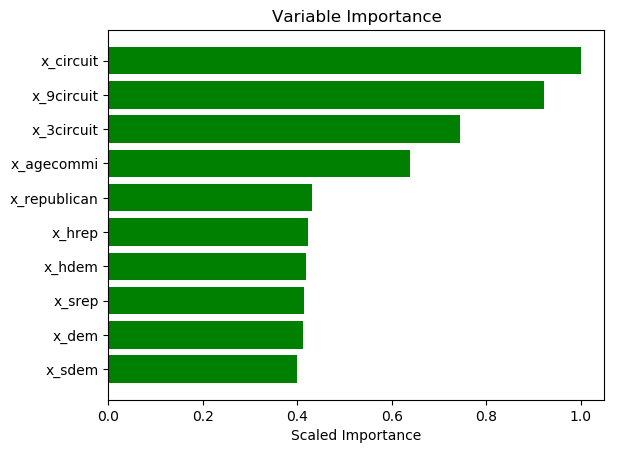

,variable,relative_importance,scaled_importance,percentage
0,x_circuit,305.487091,1.000000,0.068682
1,x_9circuit,281.487122,0.921437,0.063286
2,x_3circuit,227.216934,0.743786,0.051084
3,x_agecommi,194.800797,0.637673,0.043796
4,x_republican,131.862457,0.431647,0.029646
5,x_hrep,128.787430,0.421581,0.028955
6,x_hdem,127.507683,0.417391,0.028667
7,x_srep,126.605370,0.414438,0.028464
8,x_dem,125.983292,0.412401,0.028324
9,x_sdem,121.598640,0.398048,0.027339


In [16]:
plt.rcdefaults()
fig, ax = plt.subplots()
variables = rf_v1._model_json['output']['variable_importances']['variable']
y_pos = np.arange(10)
scaled_importance = rf_v1._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance[:10], align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

rf_v1._model_json['output']['variable_importances'].as_data_frame()

In [17]:
rf_v1.confusion_matrix(valid=True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21627565274635951: 


,1,2,Error,Rate
1,786.0,118.0,0.1305,(118.0/904.0)
2,111.0,73.0,0.6033,(111.0/184.0)
Total,897.0,191.0,0.2105,(229.0/1088.0)


### Gradient Boost

In [18]:
gbm1 = H2OGradientBoostingEstimator()
gbm1.train(train_X, train_y, training_frame=train, validation_frame=val)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [19]:
pred = gbm1.predict(val[:,:-1]).as_data_frame().as_matrix()[:,-2:].ravel()
true = pd.get_dummies(val[:,-1].as_data_frame().as_matrix().flatten()).values.ravel()
print("AUC Score calculaed by sklearn")
roc_auc_score(true, pred)

gbm prediction progress: |████████████████████████████████████████████████| 100%
AUC Score calculaed by sklearn


0.8754012691933393

In [20]:
gbm1.confusion_matrix(valid=True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1842642669531404: 


,1,2,Error,Rate
1,659.0,245.0,0.271,(245.0/904.0)
2,90.0,94.0,0.4891,(90.0/184.0)
Total,749.0,339.0,0.3079,(335.0/1088.0)


In [23]:
gbm1.model_performance(valid=True)


ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.13172315485599762
RMSE: 0.36293684692518835
LogLoss: 0.4271588889164699
Mean Per-Class Error: 0.3800740669488265
AUC: 0.6581287273951519
Gini: 0.31625745479030387
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1842642669531404: 


,1,2,Error,Rate
1,659.0,245.0,0.271,(245.0/904.0)
2,90.0,94.0,0.4891,(90.0/184.0)
Total,749.0,339.0,0.3079,(335.0/1088.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1842643,0.3594646,181.0
max f2,0.1094692,0.5309735,313.0
max f0point5,0.2931911,0.3807947,72.0
max accuracy,0.4936292,0.8354779,10.0
max precision,0.7534273,1.0,0.0
max recall,0.0616632,1.0,383.0
max specificity,0.7534273,1.0,0.0
max absolute_mcc,0.2931911,0.2345145,72.0
max min_per_class_accuracy,0.1580598,0.6061947,224.0
max mean_per_class_accuracy,0.1842643,0.6199259,181.0


Gains/Lift Table: Avg response rate: 16.91 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0101103,0.4960302,3.7628458,3.7628458,0.6363636,0.6363636,0.0380435,0.0380435,276.2845850,276.2845850
,2,0.0202206,0.4376681,2.6877470,3.2252964,0.4545455,0.5454545,0.0271739,0.0652174,168.7747036,222.5296443
,3,0.0303309,0.3909939,2.1501976,2.8669302,0.3636364,0.4848485,0.0217391,0.0869565,115.0197628,186.6930171
,4,0.0404412,0.3762562,2.1501976,2.6877470,0.3636364,0.4545455,0.0217391,0.1086957,115.0197628,168.7747036
,5,0.0514706,0.3573732,1.4782609,2.4285714,0.25,0.4107143,0.0163043,0.125,47.8260870,142.8571429
,6,0.1001838,0.2854368,2.5660377,2.4954128,0.4339623,0.4220183,0.125,0.25,156.6037736,149.5412844
,7,0.1507353,0.2478016,1.2901186,2.0911983,0.2181818,0.3536585,0.0652174,0.3152174,29.0118577,109.1198303
,8,0.2003676,0.2227850,1.2045089,1.8715596,0.2037037,0.3165138,0.0597826,0.375,20.4508857,87.1559633
,9,0.3005515,0.1870902,1.1392102,1.6274432,0.1926606,0.2752294,0.1141304,0.4891304,13.9210211,62.7443159
,10,0.3998162,0.1632509,0.7665056,1.4136932,0.1296296,0.2390805,0.0760870,0.5652174,-23.3494364,41.3693153


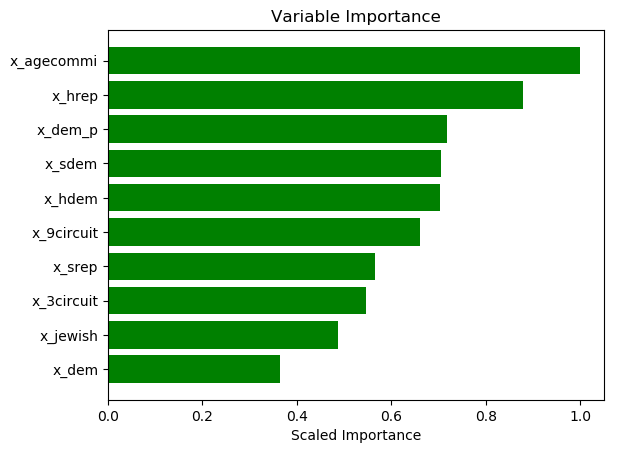

,variable,relative_importance,scaled_importance,percentage
0,x_agecommi,51.575260,1.000000,0.067587
1,x_hrep,45.281063,0.877961,0.059338
2,x_dem_p,36.962090,0.716663,0.048437
3,x_sdem,36.399849,0.705762,0.047700
4,x_hdem,36.199268,0.701873,0.047437
5,x_9circuit,34.030766,0.659827,0.044596
6,x_srep,29.162809,0.565442,0.038216
7,x_3circuit,28.201019,0.546794,0.036956
8,x_jewish,25.099342,0.486655,0.032891
9,x_dem,18.764181,0.363821,0.024589


In [22]:
plt.rcdefaults()
fig, ax = plt.subplots()
variables = gbm1._model_json['output']['variable_importances']['variable']
y_pos = np.arange(10)
scaled_importance = gbm1._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance[:10], align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

gbm1._model_json['output']['variable_importances'].as_data_frame()

In [268]:
## Depth 10 is usually plenty of depth for most datasets, but you never know
# hyper_params = {'max_depth' : range(2,20,4)}
hyper_params = {'max_depth' :[4,6,8,12,16,20]} ##faster for larger datasets

#Build initial GBM Model
gbm_grid = H2OGradientBoostingEstimator(
        ## more trees is better if the learning rate is small enough 
        ## here, use "more than enough" trees - we have early stopping
        ntrees=10000,
        ## smaller learning rate is better
        ## since we have learning_rate_annealing, we can afford to start with a 
        #bigger learning rate
        learn_rate=0.05,
        ## learning rate annealing: learning_rate shrinks by 1% after every tree 
        ## (use 1.00 to disable, but then lower the learning_rate)
        learn_rate_annealing = 0.99,
        ## sample 80% of rows per tree
        sample_rate = 0.8,
        ## sample 80% of columns per split
        col_sample_rate = 0.8,
        ## fix a random number generator seed for reproducibility
        seed = 1234,
        ## score every 10 trees to make early stopping reproducible 
        #(it depends on the scoring interval)
        score_tree_interval = 10, 
        ## early stopping once the validation AUC doesn't improve by at least 0.01% for 
        #5 consecutive scoring events
        stopping_rounds = 5,
        stopping_metric = "AUC",
        stopping_tolerance = 1e-4)

#Build grid search with previously made GBM and hyper parameters
grid = H2OGridSearch(gbm_grid,hyper_params,
                         grid_id = 'depth_grid',
                         search_criteria = {'strategy': "Cartesian"})


#Train grid search
grid.train(train_X, train_y,
           training_frame = train,
           validation_frame = val)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [206]:
## sort the grid models by decreasing AUC
sorted_grid = grid.get_grid(sort_by='auc',decreasing=True)
print(sorted_grid)

    max_depth           model_ids                 auc
0          20  depth_grid_model_5  0.6174586467016394
1          16  depth_grid_model_4  0.6168927445687543
2          12  depth_grid_model_3  0.6110696116213662
3           8  depth_grid_model_2  0.6086334029392957
4           4  depth_grid_model_0  0.6071563983724655
5           6  depth_grid_model_1  0.6036336575952554



### Top 10 -> Logistics Regression

In [26]:
top_fea = ["x_agecommi", "x_hrep", "x_dem_p", "x_sdem", "x_hdem","x_9circuit", "x_srep", "x_3circuit", "x_jewish", "x_dem"]
lr_v1 = H2OGeneralizedLinearEstimator(
                    model_id='glm_v1',            #allows us to easily locate this model in Flow
                    family='binomial',
                    solver='L_BFGS')
lr_v1.train(top_fea, train_y, training_frame = train, validation_frame = val)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [30]:
lr_v1.coef_norm()

{'Intercept': -1.579644270570838,
 'x_3circuit': 0.19226668868176233,
 'x_9circuit': 0.23672681636051732,
 'x_agecommi': -0.06891651601762336,
 'x_dem': 0.1658427589274806,
 'x_dem_p': -0.020677030266337867,
 'x_hdem': -0.03506266737721143,
 'x_hrep': 0.0057347957990354585,
 'x_jewish': 0.03487521358702875,
 'x_sdem': 0.030684177579650574,
 'x_srep': -0.02676133599535324}

In [25]:
help(H2OGeneralizedLinearEstimator)

Help on class H2OGeneralizedLinearEstimator in module h2o.estimators.glm:

class H2OGeneralizedLinearEstimator(h2o.estimators.estimator_base.H2OEstimator)
 |  Generalized Linear Modeling
 |  
 |  Fits a generalized linear model, specified by a response variable, a set of predictors, and a
 |  description of the error distribution.
 |  
 |  A subclass of :class:`ModelBase` is returned. The specific subclass depends on the machine learning task
 |  at hand (if it's binomial classification, then an H2OBinomialModel is returned, if it's regression then a
 |  H2ORegressionModel is returned). The default print-out of the models is shown, but further GLM-specific
 |  information can be queried out of the object. Upon completion of the GLM, the resulting object has
 |  coefficients, normalized coefficients, residual/null deviance, aic, and a host of model metrics including
 |  MSE, AUC (for logistic regression), degrees of freedom, and confusion matrices.
 |  
 |  Method resolution order:
 |  

## Un-sum 3 Judges

### Random Forsest

In [223]:
#modelling using only un-summed biodata
#fit a random forest
rf_v2 = H2ORandomForestEstimator(
    model_id="rf_v2",
    ntrees=120,
    max_depth = 6,
#     stopping_rounds=2,
    score_each_iteration=True,
    seed=10000)
data_bio_filt = data_bio[data_bio["res"] != 0]
data_bio_filt["res"] = data_bio_filt["res"].asfactor()
train, test, val = data_bio_filt.split_frame(ratios=[.7, .15])
train_X = train.col_names[:-1]     #last column is Cover_Type, our desired response variable 
train_y = train.col_names[-1]
rf_v2.train(train_X, train_y, training_frame=train, validation_frame=val)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [240]:
rf_v2.model_performance()


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.1420330474230797
RMSE: 0.37687272045490333
LogLoss: 0.4536058255499541
Mean Per-Class Error: 0.39911247737808964
AUC: 0.6380272985808846
Gini: 0.27605459716176917
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16470082975684974: 


,1,2,Error,Rate
1,2325.0,1921.0,0.4524,(1921.0/4246.0)
2,322.0,609.0,0.3459,(322.0/931.0)
Total,2647.0,2530.0,0.4333,(2243.0/5177.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1647008,0.3519214,249.0
max f2,0.1203184,0.5362042,335.0
max f0point5,0.2518933,0.3005544,127.0
max accuracy,0.5094048,0.8205524,1.0
max precision,0.5542339,1.0,0.0
max recall,0.0471008,1.0,399.0
max specificity,0.5542339,1.0,0.0
max absolute_mcc,0.1830801,0.1613598,218.0
max min_per_class_accuracy,0.1707574,0.5972073,237.0
max mean_per_class_accuracy,0.1830801,0.6008875,218.0


Gains/Lift Table: Avg response rate: 17.98 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100444,0.3926641,2.5664711,2.5664711,0.4615385,0.4615385,0.0257787,0.0257787,156.6471123,156.6471123
,2,0.0200889,0.3607766,2.2456622,2.4060667,0.4038462,0.4326923,0.0225564,0.0483351,124.5662233,140.6066678
,3,0.0301333,0.3386609,2.5664711,2.4595348,0.4615385,0.4423077,0.0257787,0.0741139,156.6471123,145.9534826
,4,0.0401777,0.3201886,1.9248533,2.3258645,0.3461538,0.4182692,0.0193340,0.0934479,92.4853342,132.5864455
,5,0.0500290,0.3070229,1.1993640,2.1040439,0.2156863,0.3783784,0.0118153,0.1052632,19.9363956,110.4043894
,6,0.1000579,0.2633099,1.6746472,1.8893455,0.3011583,0.3397683,0.0837809,0.1890440,67.4647181,88.9345537
,7,0.1500869,0.2401846,1.3096600,1.6961170,0.2355212,0.3050193,0.0655209,0.2545650,30.9659975,69.6117016
,8,0.2001159,0.2224068,1.3955393,1.6209726,0.2509653,0.2915058,0.0698174,0.3243824,39.5539317,62.0972591
,9,0.2999807,0.1955345,1.3121932,1.5181787,0.2359768,0.2730200,0.1310419,0.4554243,31.2193166,51.8178668
,10,0.4000386,0.1755159,1.0627569,1.4042682,0.1911197,0.2525350,0.1063373,0.5617615,6.2756865,40.4268241


In [225]:
pred = rf_v2.predict(val[:,:-1]).as_data_frame().as_matrix()[:,-2:].ravel()
true = pd.get_dummies(val[:,-1].as_data_frame().as_matrix().flatten()).values.ravel()
roc_auc_score(true, pred)

drf prediction progress: |████████████████████████████████████████████████| 100%


0.8530978672204002

In [242]:
rf_v2.confusion_matrix(valid=True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15164842498799166: 


,1,2,Error,Rate
1,381.0,554.0,0.5925,(554.0/935.0)
2,50.0,150.0,0.25,(50.0/200.0)
Total,431.0,704.0,0.5322,(604.0/1135.0)
